# 목표 : K-Nearest Neighbor 모델 구축
# 1. 데이터 전처리 
# 2. K-Nearest Neighbor 모델 구축 
## K-fold cross validation 활용
### - k 개수 선정 " 인접한 학습데이터를 몇 개까지 탐색할 것인가?"
### - Distance measure 선정 "데이터 간 거리를 어떻게 측정할 것인가?" 
# 3. 예측 결과 평가 및 weighted KNN 구축 

# ----------------------------------------------------------

# 1. 모듈 불러오기

In [29]:
from IPython.display import display, HTML
import warnings
warnings.filterwarnings(action="ignore")

#실습용 데이터 전처리
from sklearn.datasets import load_breast_cancer

#데이터 전처리 
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler

#기계학습 모델 및 평가 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, recall_score, precision_score
from tqdm import tqdm

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from scipy.stats import spearmanr

#시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from matplotlib.colors import ListedColormap
matplotlib.rcParams["axes.unicode_minus"] = False # 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처

#한글폰트설정 
plt.rc("font", family="Malgun Gothic")



# 2. 데이터 불러오기 : Breast Cancer

In [30]:
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

## 데이터 구조
### - 데이터: 위스콘신 대학교에서 제공한 유방암 진단결과
### - 관측치 개수: 569개
### - 변수 개수: 32개(ID:진단결과, 30개의 실측변수값)


## 설명변수(원인: 예측값을 설명할 수 있는 변수) 
### - id : 환자 식별 번호
### - radius : 반경(중심에서 외벽까지 거리들의 평균값)
### - texture : 질감(Gray-Scale 값들의 표준편차)
### - perimeter : 둘레
### - area : 면적
### - smoothness : 매끄러움(반경길이의 소극적 변화)
### - compactness : 조그만 정도(둘레^2/면적-1)
### - concavity : 오목함(윤곽의 오목한 정도)
### - points : 오목한 점의 수
### - symmetry : 대칭
### - dimension : 프렉탈 차원(해안선 근사-1)
### - mean : 3~12번 까지는 평균값을 의미
### - se : 13~22번까지는 표준오차를 의미 
### - worst : 23~32는 각 세포별 구분들에서 제일 큰 3개의 값을 평균낸 값


## 반응 변수(결과: 예측하고자 하는 값)
### - diagnosis : 양성여부(Maligant = 1 악성(유방암), Benign=0 양성(단순낭종))

In [31]:
breast_cancer.data.shape

(569, 30)

# 3. 탐색적 데이터 분석 및 데이터 전처리 
## X: 독립변수,예측변수,입력변수 
## y: 종속변수,반응변수,출력변수 


In [32]:
#데이터 프레임 형태로 변환 
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = pd.DataFrame(breast_cancer.target, columns=['diagnosis'])

In [33]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [34]:
y.tail()

,diagnosis
564,0
565,0
566,0
567,0
568,1


# 결측치(손실데이터), 데이터 타입 확인

In [35]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [36]:
X.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [37]:
y["diagnosis"].value_counts()

1    357
0    212
Name: diagnosis, dtype: int64

# Train/Test 데이터 분리 
## Traning 데이터 70%/Testing 데이터 30% 나누기 

In [38]:
#Train set/ Test set 나누기  #stratify=y 가 가진 뜻은 y가 가진 1,0이 비율에 맞게 나눠지도록 하는것
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.3,random_state=2021)

#데이터 칼럼 단위 정규화하기 
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

print(f'Train set dimension is {X_train.shape}')
print(f'Test set dimension is {X_test.shape}')




Train set dimension is (398, 30)
Test set dimension is (171, 30)


# 모델링 
## k 개수 결정 
## Distance measure 결정 

### k에 따른 결과 
#### k가 매우 작을 경우 overfitting k가 매우 클 경우 underfitting, 적절한 k값 찾아야함

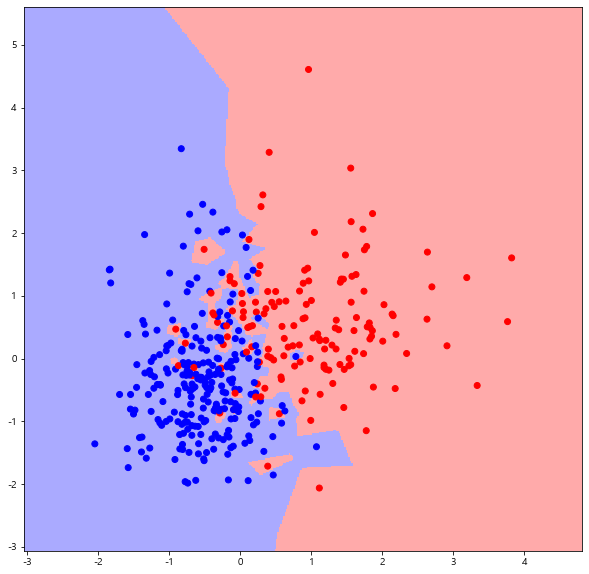

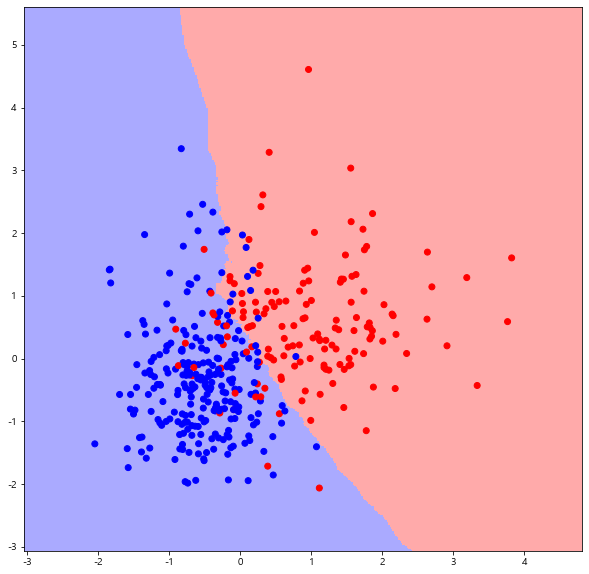

In [39]:
X_vis = X_train[:,:2]  #시각화를 위해 임의로 앞에 두개변수로 보여줌
y_vis = y_train.values.ravel()

h= .02

# 컬러맵 만들기
cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
cmap_bold = ListedColormap(["#FF0000","#00FF00","#0000FF"])

for k in [1,50]:
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_vis,y_vis)
    
    x_min, x_max = X_vis[:,0].min() - 1, X_vis[:,0].max() + 1
    y_min, y_max = X_vis[:,1].min() - 1, X_vis[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10,10))
    plt.pcolormesh(xx,yy,Z,cmap = cmap_light)
    
    plt.scatter(X_vis[:,0], X_vis[:,1], c=y_vis, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
